In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from nltk.stem.snowball import SnowballStemmer
#导入train,test,product_descriptions数据集
df_train=pd.read_csv('train.csv',encoding='ISO-8859-1')
df_test=pd.read_csv('test.csv',encoding='ISO-8859-1')
df_desc=pd.read_csv('product_descriptions.csv')

In [11]:
#合并训练数据及测试数据
df_all=pd.concat([df_train.assign(is_train=1),df_test.assign(is_train=0)],axis=0,ignore_index=True)
df_all = pd.merge(df_all, df_desc, how='left', on='product_uid')
df_all

,id,product_uid,product_title,search_term,relevance,is_train,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,1,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,1,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,1,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,1,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,1,Update your bathroom with the Delta Vero Singl...
...,...,...,...,...,...,...,...
240755,240756,224424,stufurhome Norma 24 in. W x 16 in. D x 34 in. ...,24 whtie storage cabinet,NaN,0,Create a neat yet stylish storage space for or...
240756,240757,224425,Home Decorators Collection 49 in. D Alessandro...,adirondeck cusion,NaN,0,Our Bullnose Adirondack Chair Cushions fit Adi...
240757,240758,224426,Simpson Strong-Tie HB 3-1/2 x 14 in. Top Flang...,hb,NaN,0,Joist hangers are designed to provide support ...
240758,240759,224427,1/4 in. -20 tpi x 1-1/2 in. Stainless Steel Bu...,hex sockets,NaN,0,These socket cap screws are ideal for applicat...


In [12]:
stemmer = SnowballStemmer('english')
#把每一列中的每一条产品说明中的英文句子，小写lower() -> 分割split() -> 提取词干stemmer.stem -> 整合join
def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])
#计算"关键词次数" ： 统计两个字符串中的相同单词的个数
#python find()方法：http://www.runoob.com/python/att-string-find.html
def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())

In [13]:
from nltk.corpus import stopwords 
dic_stopwords = dict(zip(stopwords.words('english'),range(len(stopwords.words('english')))))

In [14]:
from nltk import SnowballStemmer  
from nltk.corpus import stopwords
import re
import Levenshtein
stemmer = SnowballStemmer('english')

pattern_replace_pair_list = [
            (r"<.+?>", r""),
            # html codes
            (r"&nbsp;", r" "),
            (r"&amp;", r"&"),
            (r"&#39;", r"'"),
            (r"/>/Agt/>", r""),
            (r"</a<gt/", r""),
            (r"gt/>", r""),
            (r"/>", r""),
            (r"<br", r""),
            # do not remove [".", "/", "-", "%"] as they are useful in numbers, e.g., 1.97, 1-1/2, 10%, etc.
            (r"[ &<>)(_,;:!?\+^~@#\$\*]+", r" "),
            (r"'s\\b", r""),
            (r"[']+", r""),
    # 将DeckOver这样次分开，字母与字符英文连在一起的也分开
            #(r'([A-Z][a-z]+|[a-z]+|\d+)', r'\1 '),
            (r'(\d?)([a-zA-Z]+)', r'\1 \2 '),
            #(r'(/d+)', r' \1 '),
            (r'([A-Z][a-z]+)', r' \1 '),
        ]
dic = {1:'one', 2:'two', 3:'three', 4:'four', 5:'five',6:'six', 7:'seven', 8:'eight', 9:'night',0:'zero'}
def dashrep(matchobj):
    if len(matchobj.group())==1:
        return dic[int(matchobj.group())]
    else:
        return matchobj.group() 

# 小写 去除标点符号，停用词
def transform(text):
    for pattern, replace in pattern_replace_pair_list:
        try:
            text = re.sub(pattern, replace, text)
        except:
            pass
    #text = re.sub(r'[\d]+', dashrep, text)
    text = re.sub(r"\s+", " ", text).strip()
    return ' '.join([word for word in text.lower().split() if word not in dic_stopwords])

#word_list = "Package stopwords is already up-to-date".split(" ")
#filtered_words = [word for word in word_list if word not in stopwords.words('english')]

In [15]:
%time df_all['search_term_transform'] = df_all['search_term'].map(lambda x:transform(x))
%time df_all['product_title_transform'] = df_all['product_title'].map(lambda x:transform(x))
%time df_all['pro_des_trans'] = df_all['product_description'].map(lambda x:transform(x))

Wall time: 5.19 s
Wall time: 11.4 s
Wall time: 1min 17s


In [16]:
stemmer = SnowballStemmer('english')
#把每一列中的每一条产品说明中的英文句子，小写lower() -> 分割split() -> 提取词干stemmer.stem -> 整合join
def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])
#计算"关键词次数" ： 统计两个字符串中的相同单词的个数
#python find()方法：http://www.runoob.com/python/att-string-find.html
def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())

In [17]:
%time df_all['search_term'] = df_all['search_term_transform'].map(lambda x: str_stemmer(x))
%time df_all['product_title'] = df_all['product_title_transform'].map(lambda x: str_stemmer(x))
%time df_all['product_description'] = df_all['pro_des_trans'].map(lambda x: str_stemmer(x))

Wall time: 8.07 s
Wall time: 26.2 s
Wall time: 4min 49s


In [18]:
df_all

,id,product_uid,product_title,search_term,relevance,is_train,product_description,search_term_transform,product_title_transform,pro_des_trans
0,2,100001,simpson strong - tie 12- gaug angl,angl bracket,3.00,1,angl make joint stronger also provid consist s...,angle bracket,simpson strong - tie 12- gauge angle,angles make joints stronger also provide consi...
1,3,100001,simpson strong - tie 12- gaug angl,l bracket,2.50,1,angl make joint stronger also provid consist s...,l bracket,simpson strong - tie 12- gauge angle,angles make joints stronger also provide consi...
2,9,100002,behr premium textur deck 1- gal . sc -141 tugb...,deck,3.00,1,behr premium textur deckov innov solid color c...,deck,behr premium textured deck 1- gal . sc -141 tu...,behr premium textured deckover innovative soli...
3,16,100005,delta vero 1- handl shower faucet trim kit chr...,rain shower head,2.33,1,updat bathroom delta vero singl - handl shower...,rain shower head,delta vero 1- handle shower faucet trim kit ch...,update bathroom delta vero single - handle sho...
4,17,100005,delta vero 1- handl shower faucet trim kit chr...,shower faucet,2.67,1,updat bathroom delta vero singl - handl shower...,shower faucet,delta vero 1- handle shower faucet trim kit ch...,update bathroom delta vero single - handle sho...
...,...,...,...,...,...,...,...,...,...,...
240755,240756,224424,stufurhom norma 24 . w x 16 . x 34 . h linen s...,24 whtie storag cabinet,NaN,0,creat neat yet stylish storag space organ bath...,24 whtie storage cabinet,stufurhome norma 24 . w x 16 . x 34 . h linen ...,create neat yet stylish storage space organizi...
240756,240757,224425,home decor collect 49 . alessandro spiceberri ...,adirondeck cusion,NaN,0,bullnos adirondack chair cushion fit adirondac...,adirondeck cusion,home decorators collection 49 . alessandro spi...,bullnose adirondack chair cushions fit adirond...
240757,240758,224426,simpson strong - tie hb 3-1/2 x 14 . top flang...,hb,NaN,0,joist hanger design provid support underneath ...,hb,simpson strong - tie hb 3-1/2 x 14 . top flang...,joist hangers designed provide support underne...
240758,240759,224427,1/4 . -20 tpi x 1-1/2 . stainless steel button...,hex socket,NaN,0,socket cap screw ideal applic requir well tool...,hex sockets,1/4 . -20 tpi x 1-1/2 . stainless steel button...,socket cap screws ideal applications require w...


In [19]:
#关键字的长度
%time df_all['len_of_query'] = df_all['search_term'].map(lambda x: len(x.split())).astype(np.int64)
#搜索词与标题中有多少关键字重合
%time df_all['commons_in_title'] = df_all.apply(lambda x:str_common_word(x['search_term'], x['product_title']), axis=1)
#搜索词与描述中有多少关键字重合
#df_all['commons_in_desc'] = df_all.apply(lambda x: str_common_word(x['search_term'], x['product_description'], axis = 1)
%time df_all['commons_in_desc'] = df_all.apply(lambda x: str_common_word(x['search_term'], x['product_description']), axis=1)

Wall time: 134 ms
Wall time: 2.71 s
Wall time: 2.7 s


In [20]:
df_all = df_all.drop(['search_term_transform','product_title_transform','pro_des_trans'],axis=1)
df_all

,id,product_uid,product_title,search_term,relevance,is_train,product_description,len_of_query,commons_in_title,commons_in_desc
0,2,100001,simpson strong - tie 12- gaug angl,angl bracket,3.00,1,angl make joint stronger also provid consist s...,2,1,1
1,3,100001,simpson strong - tie 12- gaug angl,l bracket,2.50,1,angl make joint stronger also provid consist s...,2,1,1
2,9,100002,behr premium textur deck 1- gal . sc -141 tugb...,deck,3.00,1,behr premium textur deckov innov solid color c...,1,1,1
3,16,100005,delta vero 1- handl shower faucet trim kit chr...,rain shower head,2.33,1,updat bathroom delta vero singl - handl shower...,3,1,1
4,17,100005,delta vero 1- handl shower faucet trim kit chr...,shower faucet,2.67,1,updat bathroom delta vero singl - handl shower...,2,2,2
...,...,...,...,...,...,...,...,...,...,...
240755,240756,224424,stufurhom norma 24 . w x 16 . x 34 . h linen s...,24 whtie storag cabinet,NaN,0,creat neat yet stylish storag space organ bath...,4,3,3
240756,240757,224425,home decor collect 49 . alessandro spiceberri ...,adirondeck cusion,NaN,0,bullnos adirondack chair cushion fit adirondac...,2,0,0
240757,240758,224426,simpson strong - tie hb 3-1/2 x 14 . top flang...,hb,NaN,0,joist hanger design provid support underneath ...,1,1,1
240758,240759,224427,1/4 . -20 tpi x 1-1/2 . stainless steel button...,hex socket,NaN,0,socket cap screw ideal applic requir well tool...,2,2,2


In [21]:
#Levenshtein文本相似度
import Levenshtein
df_all['dist_in_title']=df_all.apply(lambda x:Levenshtein.ratio(x['search_term'],x['product_title']),axis=1)
df_all['dist_in_desc']=df_all.apply(lambda x:Levenshtein.ratio(x['search_term'],x['product_description']),axis=1)

In [22]:
df_all

,id,product_uid,product_title,search_term,relevance,is_train,product_description,len_of_query,commons_in_title,commons_in_desc,dist_in_title,dist_in_desc
0,2,100001,simpson strong - tie 12- gaug angl,angl bracket,3.00,1,angl make joint stronger also provid consist s...,2,1,1,0.173913,0.039539
1,3,100001,simpson strong - tie 12- gaug angl,l bracket,2.50,1,angl make joint stronger also provid consist s...,2,1,1,0.139535,0.029801
2,9,100002,behr premium textur deck 1- gal . sc -141 tugb...,deck,3.00,1,behr premium textur deckov innov solid color c...,1,1,1,0.112676,0.010323
3,16,100005,delta vero 1- handl shower faucet trim kit chr...,rain shower head,2.33,1,updat bathroom delta vero singl - handl shower...,3,1,1,0.389610,0.064257
4,17,100005,delta vero 1- handl shower faucet trim kit chr...,shower faucet,2.67,1,updat bathroom delta vero singl - handl shower...,2,2,2,0.351351,0.052525
...,...,...,...,...,...,...,...,...,...,...,...,...
240755,240756,224424,stufurhom norma 24 . w x 16 . x 34 . h linen s...,24 whtie storag cabinet,NaN,0,creat neat yet stylish storag space organ bath...,4,3,3,0.468085,0.076795
240756,240757,224425,home decor collect 49 . alessandro spiceberri ...,adirondeck cusion,NaN,0,bullnos adirondack chair cushion fit adirondac...,2,0,0,0.268908,0.056478
240757,240758,224426,simpson strong - tie hb 3-1/2 x 14 . top flang...,hb,NaN,0,joist hanger design provid support underneath ...,1,1,1,0.063492,0.009732
240758,240759,224427,1/4 . -20 tpi x 1-1/2 . stainless steel button...,hex socket,NaN,0,socket cap screw ideal applic requir well tool...,2,2,2,0.196078,0.043860


In [23]:
#TF-IDF
'''
我们首先搞一个新的column，叫all_texts, 里面是所有的texts。
（我并没有算上search term, 因为他们不是一个结构完整的句子，
可能会影响tfidf的学习）。为了防止句子格式不完整，我们也强制给他们
加上句号。

注意：这里我们最严谨的做法是把train/test先分开，
然后只在train上做tfidf的学习，并在test上直接转化。
但由于kaggle提前拿到test，这里姑且把文本内容汇总一起，
实际项目中，往往是没法提前拿到test的。
'''
df_all['all_texts']=df_all['product_title']+'.'+df_all['product_description']+'.'
#然后，我们取出所有的单字，做成一个我们的单词字典
from gensim.utils import tokenize
from gensim.corpora.dictionary import Dictionary
dictionary=Dictionary(list(tokenize(x,errors='ignore')) for x in df_all['all_texts'].values)
#print(dictionary)

#下面写一个类，扫便我们所有的语料，并且转化成简单的单词的个数计算(Bag-of-Words)
class MyCorpus(object):
    def __iter__(self):
        for x in df_all['all_texts'].values:
            yield dictionary.doc2bow(list(tokenize(x,errors='ignore')))

corpus=MyCorpus()

#有了标准形式的语料库，就可以把已经变成BoW向量的数组，做一次TFIDF计算
from gensim.models.tfidfmodel import TfidfModel
tfidf=TfidfModel(corpus)

#判断两个句子的相似度：把其中一个作为index，扩展开全部的matrixsize，另一个带入，就可以计算
from gensim.similarities import MatrixSimilarity

def to_tfidf(text):
    res=tfidf[dictionary.doc2bow(list(tokenize(text,errors='ignore')))]
    return res
#然后，创造一个cosine similarity的比较方法
def cos_sim(text1,text2):
    tfidf1=to_tfidf(text1)
    tfidf2=to_tfidf(text2)
    index=MatrixSimilarity([tfidf1],num_features=len(dictionary))
    sim=index[tfidf2]
    #sim输出的是一个array,我们只需要数值
    return float(sim[0])


F:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [24]:
#计算TFIDF相似度
#计算TFIDF相似度
%time df_all['tfidf_cos_sim_in_title']=df_all.apply(lambda x:cos_sim(x['search_term'],x['product_title']),axis=1)
%time df_all['tfidf_cos_sim_in_desc'] = df_all.apply(lambda x: cos_sim(x['search_term'], x['product_description']), axis=1)

Wall time: 1min 10s
Wall time: 3min 16s


In [25]:
df_all

,id,product_uid,product_title,search_term,relevance,is_train,product_description,len_of_query,commons_in_title,commons_in_desc,dist_in_title,dist_in_desc,all_texts,tfidf_cos_sim_in_title,tfidf_cos_sim_in_desc
0,2,100001,simpson strong - tie 12- gaug angl,angl bracket,3.00,1,angl make joint stronger also provid consist s...,2,1,1,0.173913,0.039539,simpson strong - tie 12- gaug angl.angl make j...,0.270386,0.191815
1,3,100001,simpson strong - tie 12- gaug angl,l bracket,2.50,1,angl make joint stronger also provid consist s...,2,1,1,0.139535,0.029801,simpson strong - tie 12- gaug angl.angl make j...,0.000000,0.000000
2,9,100002,behr premium textur deck 1- gal . sc -141 tugb...,deck,3.00,1,behr premium textur deckov innov solid color c...,1,1,1,0.112676,0.010323,behr premium textur deck 1- gal . sc -141 tugb...,0.194095,0.212764
3,16,100005,delta vero 1- handl shower faucet trim kit chr...,rain shower head,2.33,1,updat bathroom delta vero singl - handl shower...,3,1,1,0.389610,0.064257,delta vero 1- handl shower faucet trim kit chr...,0.137359,0.051747
4,17,100005,delta vero 1- handl shower faucet trim kit chr...,shower faucet,2.67,1,updat bathroom delta vero singl - handl shower...,2,2,2,0.351351,0.052525,delta vero 1- handl shower faucet trim kit chr...,0.355233,0.133826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240755,240756,224424,stufurhom norma 24 . w x 16 . x 34 . h linen s...,24 whtie storag cabinet,NaN,0,creat neat yet stylish storag space organ bath...,4,3,3,0.468085,0.076795,stufurhom norma 24 . w x 16 . x 34 . h linen s...,0.214326,0.136015
240756,240757,224425,home decor collect 49 . alessandro spiceberri ...,adirondeck cusion,NaN,0,bullnos adirondack chair cushion fit adirondac...,2,0,0,0.268908,0.056478,home decor collect 49 . alessandro spiceberri ...,0.000000,0.000000
240757,240758,224426,simpson strong - tie hb 3-1/2 x 14 . top flang...,hb,NaN,0,joist hanger design provid support underneath ...,1,1,1,0.063492,0.009732,simpson strong - tie hb 3-1/2 x 14 . top flang...,0.575047,0.207460
240758,240759,224427,1/4 . -20 tpi x 1-1/2 . stainless steel button...,hex socket,NaN,0,socket cap screw ideal applic requir well tool...,2,2,2,0.196078,0.043860,1/4 . -20 tpi x 1-1/2 . stainless steel button...,0.507096,0.408026


In [26]:
#Word2Vec
#w2v和tfidf不同，对tfidf而言，只需要知道一整段text中包含了哪些word元素就行了。
#而w2v要考虑到句子层级的split，以及语境前后的考虑.
import nltk
#句子分割,把长文本分割成list of 句子,再把句子变成list of 单词
tokenizer=nltk.data.load('tokenizers/punkt/english.pickle')
sentences=[tokenizer.tokenize(x) for x in df_all['all_texts'].values]
#其实这些sentences不需要层级关系，我们把list of lists给flatten了
sentences=[y for x in sentences for y in x]

#把单词分好
from nltk.tokenize import word_tokenize
w2v_corpus=[word_tokenize(x) for x in sentences]

#训练model
from gensim.models.word2vec import Word2Vec
model=Word2Vec(w2v_corpus,size=128,window=5,min_count=5,workers=4)

#TFIDF是针对每个句子都可以有的，而w2v是针对每个单词的
#这里我们平均化一个句子的w2v向量，算作整个text的平均vector

#先拿到全部的vocabulary
vocab=model.wv.vocab

#得到任意text的vector
def get_vector(text):
    res=np.zeros([128])
    count=0
    for word in word_tokenize(text):
        if word in vocab:
            res+=model[word]
            count+=1
    return res/count

#计算两个text的平均w2v的cosine similarity
from scipy import spatial

def w2v_cos_sim(text1,text2):
        w2v1=get_vector(text1)
        w2v2=get_vector(text2)
        sim=1-spatial.distance.cosine(w2v1,w2v2)
        if str(sim)=='nan':
            sim=1
        else:
            pass
        return float(sim)


In [27]:
#构建w2v相似度特征
%time df_all['w2v_cos_sim_in_title']=df_all.apply(lambda x:w2v_cos_sim(x['search_term'],x['product_title']),axis=1)
%time df_all['w2v_cos_sim_in_desc']=df_all.apply(lambda x:w2v_cos_sim(x['search_term'],x['product_description']),axis=1)

F:\anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
F:\anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


Wall time: 1min 29s


F:\anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
F:\anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


Wall time: 6min 3s


In [28]:
df_all

,id,product_uid,product_title,search_term,relevance,is_train,product_description,len_of_query,commons_in_title,commons_in_desc,dist_in_title,dist_in_desc,all_texts,tfidf_cos_sim_in_title,tfidf_cos_sim_in_desc,w2v_cos_sim_in_title,w2v_cos_sim_in_desc
0,2,100001,simpson strong - tie 12- gaug angl,angl bracket,3.00,1,angl make joint stronger also provid consist s...,2,1,1,0.173913,0.039539,simpson strong - tie 12- gaug angl.angl make j...,0.270386,0.191815,0.393470,0.476581
1,3,100001,simpson strong - tie 12- gaug angl,l bracket,2.50,1,angl make joint stronger also provid consist s...,2,1,1,0.139535,0.029801,simpson strong - tie 12- gaug angl.angl make j...,0.000000,0.000000,0.280904,0.275490
2,9,100002,behr premium textur deck 1- gal . sc -141 tugb...,deck,3.00,1,behr premium textur deckov innov solid color c...,1,1,1,0.112676,0.010323,behr premium textur deck 1- gal . sc -141 tugb...,0.194095,0.212764,0.493544,0.358379
3,16,100005,delta vero 1- handl shower faucet trim kit chr...,rain shower head,2.33,1,updat bathroom delta vero singl - handl shower...,3,1,1,0.389610,0.064257,delta vero 1- handl shower faucet trim kit chr...,0.137359,0.051747,0.543286,0.367758
4,17,100005,delta vero 1- handl shower faucet trim kit chr...,shower faucet,2.67,1,updat bathroom delta vero singl - handl shower...,2,2,2,0.351351,0.052525,delta vero 1- handl shower faucet trim kit chr...,0.355233,0.133826,0.799418,0.565387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240755,240756,224424,stufurhom norma 24 . w x 16 . x 34 . h linen s...,24 whtie storag cabinet,NaN,0,creat neat yet stylish storag space organ bath...,4,3,3,0.468085,0.076795,stufurhom norma 24 . w x 16 . x 34 . h linen s...,0.214326,0.136015,0.604527,0.580506
240756,240757,224425,home decor collect 49 . alessandro spiceberri ...,adirondeck cusion,NaN,0,bullnos adirondack chair cushion fit adirondac...,2,0,0,0.268908,0.056478,home decor collect 49 . alessandro spiceberri ...,0.000000,0.000000,1.000000,1.000000
240757,240758,224426,simpson strong - tie hb 3-1/2 x 14 . top flang...,hb,NaN,0,joist hanger design provid support underneath ...,1,1,1,0.063492,0.009732,simpson strong - tie hb 3-1/2 x 14 . top flang...,0.575047,0.207460,0.059675,-0.196394
240758,240759,224427,1/4 . -20 tpi x 1-1/2 . stainless steel button...,hex socket,NaN,0,socket cap screw ideal applic requir well tool...,2,2,2,0.196078,0.043860,1/4 . -20 tpi x 1-1/2 . stainless steel button...,0.507096,0.408026,0.664336,0.571221


In [29]:
#删除相关特征
df_all=df_all.drop(['search_term','product_title','product_description','all_texts'],axis=1)
df_all

,id,product_uid,relevance,is_train,len_of_query,commons_in_title,commons_in_desc,dist_in_title,dist_in_desc,tfidf_cos_sim_in_title,tfidf_cos_sim_in_desc,w2v_cos_sim_in_title,w2v_cos_sim_in_desc
0,2,100001,3.00,1,2,1,1,0.173913,0.039539,0.270386,0.191815,0.393470,0.476581
1,3,100001,2.50,1,2,1,1,0.139535,0.029801,0.000000,0.000000,0.280904,0.275490
2,9,100002,3.00,1,1,1,1,0.112676,0.010323,0.194095,0.212764,0.493544,0.358379
3,16,100005,2.33,1,3,1,1,0.389610,0.064257,0.137359,0.051747,0.543286,0.367758
4,17,100005,2.67,1,2,2,2,0.351351,0.052525,0.355233,0.133826,0.799418,0.565387
...,...,...,...,...,...,...,...,...,...,...,...,...,...
240755,240756,224424,NaN,0,4,3,3,0.468085,0.076795,0.214326,0.136015,0.604527,0.580506
240756,240757,224425,NaN,0,2,0,0,0.268908,0.056478,0.000000,0.000000,1.000000,1.000000
240757,240758,224426,NaN,0,1,1,1,0.063492,0.009732,0.575047,0.207460,0.059675,-0.196394
240758,240759,224427,NaN,0,2,2,2,0.196078,0.043860,0.507096,0.408026,0.664336,0.571221


In [22]:

#重塑训练/测试集
df_train=df_all.loc[df_all['is_train']==1]
df_test=df_all.loc[df_all['is_train']==0]

#记录下测试集的id
test_ids=df_test['id']
#分离出y_train
y_train=df_train['relevance'].values
#把原集中的label删去
X_train=df_train.drop(['id','relevance','is_train'],axis=1).values
X_test=df_test.drop(['id','relevance','is_train'],axis=1).values

Text(0.5,1,'Param vs CV Error')

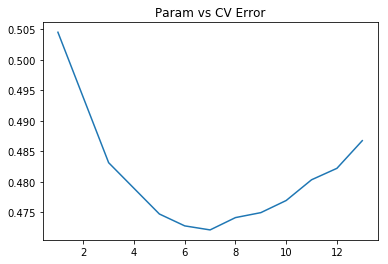

In [23]:
#建立模型
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import xgboost as XGboost
params=[1,3,5,6,7,8,9,10,11,12,13]
test_scores=[]
for param in params:
    clf=GradientBoostingRegressor(n_estimators=20,max_depth=param)
    test_score=np.sqrt(-cross_val_score(clf,X_train,y_train,cv=5,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params,test_scores)
plt.title('Param vs CV Error')

Text(0.5,1,'Param vs CV Error')

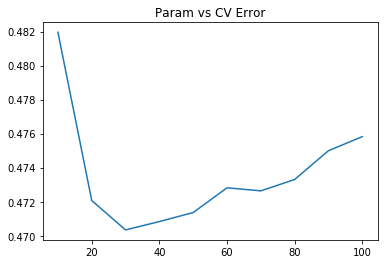

In [24]:
#建立模型

params=range(10,101,10)
test_scores=[]
for param in params:
    clf=GradientBoostingRegressor(n_estimators=param,max_depth=7)
    test_score=np.sqrt(-cross_val_score(clf,X_train,y_train,cv=5,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params,test_scores)
plt.title('Param vs CV Error')

In [27]:
rf=GradientBoostingRegressor(n_estimators=30,max_depth=7)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
pd.DataFrame({'id':test_ids,'relevance':y_pred}).to_csv('submissiongbrr.csv',index=False)